<a href="https://colab.research.google.com/github/moexalgo/moexalgo.github.io/blob/main/examples/library-examples/websocket/streams/orderbooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install moexalgo
#!pip install matplotlib

import pandas as pd
import matplotlib.pyplot as plt
from moexalgo.beta import issplus

# Данные для входа
ws_login = 'ваш_логин'
ws_passcode = 'ваш_пароль'

ticker = 'SBER'

async def websocket_orderbook():
    url = 'wss://iss.moex.com/infocx/v3/websocket'
    credentials = issplus.Credentials('passport', ws_login, ws_passcode)
    
    prev_snapshot = None
    count = 0
    
    async with issplus.connect(url, credentials) as client:
        # Подписка на стакан заявок (orderbooks)
        destination = 'MXSE.orderbooks'
        selector = f'TICKER="MXSE.TQBR.{ticker}"'
        
        subscription = await client.subscribe(destination, selector)
        print(f"Подписка ID: {subscription.id}\n")
        
        async for data in subscription:
            count += 1
            
            # Обработка данных стакана
            df = pd.DataFrame(data['data'], columns=data['columns'])
            df['price'] = df['PRICE'].apply(lambda x: x[0])
            df['qty'] = df['QUANTITY']
            
            # Разделение на заявки на покупку (BID) и продажу (ASK)
            bids = df[df['BUYSELL'] == 'B'].copy()
            asks = df[df['BUYSELL'] == 'S'].copy()
            
            print(f"\nСнэпшот (snapshot) #{count}")
            print(f"Спред: {asks['price'].min():.2f} - {bids['price'].max():.2f} = {asks['price'].min() - bids['price'].max():.2f}")
            
            
            print("\nBID (покупка)          ASK (продажа)")
            for i in range(min(5, len(bids))):
                bid_price = bids.iloc[-(i+1)]['price']
                bid_qty = bids.iloc[-(i+1)]['qty']
                ask_price = asks.iloc[i]['price']
                ask_qty = asks.iloc[i]['qty']
                print(f"{bid_price:>7.2f} x {bid_qty:<6}       {ask_price:>7.2f} x {ask_qty:<6}")
            
            
            # Сравнение с предыдущим снэпшотом (snapshot) для отслеживания изменений объемов
            if prev_snapshot is not None:
                prev_df = prev_snapshot
                
                changes = []
                for _, row in df.iterrows():
                    price = row['price']
                    qty = row['qty']
                    side = row['BUYSELL']
                    
                    prev_row = prev_df[(prev_df['price'] == price) & (prev_df['BUYSELL'] == side)]
                    if not prev_row.empty:
                        prev_qty = prev_row.iloc[0]['qty']
                        if qty != prev_qty:
                            changes.append((side, price, prev_qty, qty, qty - prev_qty))
                
                if changes:
                    print("\nИзменения:")
                    for side, price, old_qty, new_qty, diff in changes[:3]:
                        print(f"{price:.2f}: {old_qty} → {new_qty} ({diff:+d})")
            
            prev_snapshot = df.copy()
            
            # Остановка после пяти итераций (для примера)
            if count >= 5:
                break
    
    return prev_snapshot


orderbook_snapshot = await websocket_orderbook()

Подписка ID: 90cd3b43-0d3d-40e6-953b-439fb5d9c3d7


Снэпшот (snapshot) #1
Спред: 306.26 - 306.24 = 0.02

BID (покупка)          ASK (продажа)
 306.24 x 784           306.26 x 1499  
 306.23 x 16744         306.27 x 10    
 306.22 x 10            306.29 x 225   
 306.21 x 734           306.30 x 61    
 306.20 x 1730          306.31 x 1005  

Снэпшот (snapshot) #2
Спред: 306.26 - 306.24 = 0.02

BID (покупка)          ASK (продажа)
 306.24 x 785           306.26 x 1499  
 306.23 x 16744         306.27 x 10    
 306.22 x 10            306.29 x 225   
 306.21 x 734           306.30 x 61    
 306.20 x 1730          306.31 x 1005  

Изменения:
306.24: 784 → 785 (+1)

Снэпшот (snapshot) #3
Спред: 306.26 - 306.24 = 0.02

BID (покупка)          ASK (продажа)
 306.24 x 786           306.26 x 1498  
 306.23 x 16744         306.27 x 10    
 306.22 x 10            306.29 x 225   
 306.21 x 734           306.30 x 61    
 306.20 x 1730          306.31 x 1005  

Изменения:
306.24: 785 → 786 (+1)
306.26

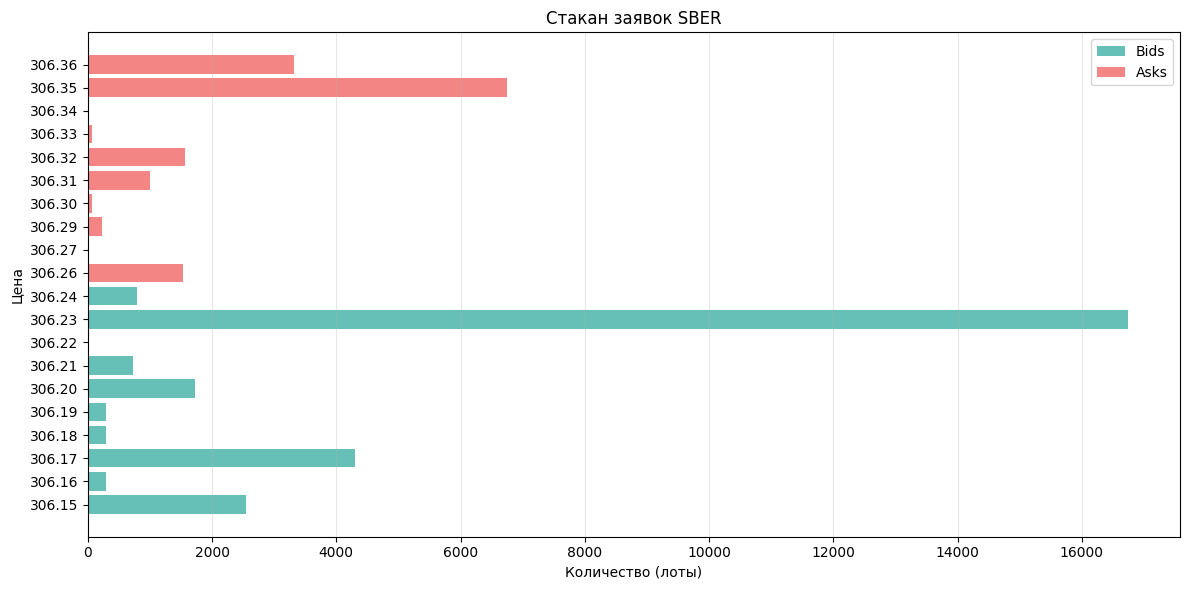

In [5]:
if orderbook_snapshot is not None:
    bids = orderbook_snapshot[orderbook_snapshot['BUYSELL'] == 'B'].sort_values('price')
    asks = orderbook_snapshot[orderbook_snapshot['BUYSELL'] == 'S'].sort_values('price')
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.barh(range(len(bids)), bids['qty'].values, color='#26a69a', alpha=0.7, label='Bids')
    ax.barh(range(len(bids), len(bids) + len(asks)), asks['qty'].values, color='#ef5350', alpha=0.7, label='Asks')
    
    all_prices = list(bids['price'].values) + list(asks['price'].values)
    ax.set_yticks(range(len(all_prices)))
    ax.set_yticklabels([f'{p:.2f}' for p in all_prices])
    
    ax.set_xlabel('Количество (лоты)')
    ax.set_ylabel('Цена')
    ax.set_title(f'Стакан заявок {ticker}')
    ax.legend()
    ax.grid(alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()

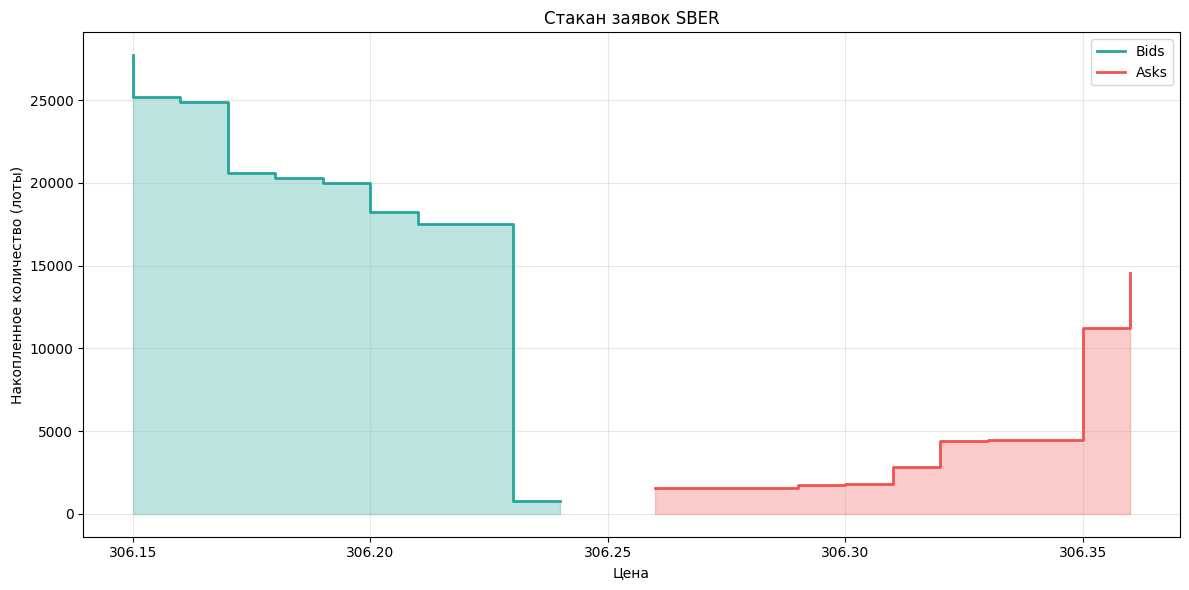

In [6]:
if orderbook_snapshot is not None:
    bids = orderbook_snapshot[orderbook_snapshot['BUYSELL'] == 'B'].sort_values('price', ascending=False)
    asks = orderbook_snapshot[orderbook_snapshot['BUYSELL'] == 'S'].sort_values('price')
    
    bids['cumqty'] = bids['qty'].cumsum()
    asks['cumqty'] = asks['qty'].cumsum()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.step(bids['price'], bids['cumqty'], where='post', color='#26a69a', linewidth=2, label='Bids')
    ax.step(asks['price'], asks['cumqty'], where='post', color='#ef5350', linewidth=2, label='Asks')
    
    ax.fill_between(bids['price'], bids['cumqty'], step='post', color='#26a69a', alpha=0.3)
    ax.fill_between(asks['price'], asks['cumqty'], step='post', color='#ef5350', alpha=0.3)
    
    ax.set_xlabel('Цена')
    ax.set_ylabel('Накопленное количество (лоты)')
    ax.set_title(f'Стакан заявок {ticker}')
    ax.legend()
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()